# ETH Exploration <a class="anchor" id="top"></a>

## Purpose
Practicing Python by exploring the price of Ethereum, a decentralized cryptocurrency.

## Methodology
1. Manipulate the data(creating new columns) to feed the Machine Learning Model and Scenario Exploration.
2. Explore the data by trying to find certain candle structure scenarios that have an above average chance of being profitable.
3. Create 3 different types of machine learning models, test their accuracy, and try to improve their accuracy.
4. Create a program outside of Jupyter Notebooks that Automates retrieving new data from yfinance and then alerts me via email/sms when the ML model finds a "good trade" based on the Scenario Exploration.

## Table of Contents
* [Data Manipulation](#data_manipulation)
* [Basic Data Exploration](#explore)
* [Scenario Exploration](#scenario)
* [Machine Learning](#ml)
    * [Linear Regression](#lr)
    * [Random Forest Classifier](#rfc)
    * [XGBoost](#xgb)
    * [Quick Test Function](#function)

## Hypotheses
- For the Machine Learning Models: 
    - The models will be more accurate predicting tomorrow's price direction vs next week's price direction.
    - The Random Forest Model will give us the best accuracy out of all the Machine Learning models.
    - We will be able to train a model with predictors good enough to predict 60% of next day's price.
- For Scenario Exploration: 
    - We will find at least 3 scenarios where price goes up 60% of the time a week after the trade scenario happens. 

## Interesting Results
- For the Machine Learning Models: 
    - It was more accurate predicting next week's price direction vs tomorrow's for Random Forest and XGBoost, but not for logistic regression.
    - Each Machine Learning Model achieved more than 60% accuracy when predicting just the last 100 days. 
- For Scenario Exploration:
    - We found more than 3 scenarios where the odds of it being profitable a week later were greater than 60%.

## *Suggested next steps*
- *Create a profitable trade management model in another Jupyter Notebook using the data we explored.*
- *Create and deploy a bot trading algorithm to trade based on your data in this notebook and in the trade management model*.
- *Create additional predictors for the machine learning model. For example using rolling averages or other technical indicators.*

## Library import

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Price Data
import yfinance as yf
import datetime as dt

# Options for pandas
pd.options.display.max_columns=60
pd.options.display.max_rows=2000

# Visualizations
import matplotlib.pyplot as plt

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2


## Data Importing (Ethereum, Dollar Index, Nasdaq)

In [2]:
# Creating a start and end date of all the imported data based on ETH's oldest trading date. 
start = dt.datetime(2017,11,7)
end = dt.datetime.now()

# Importing Ethereum Data
eth = yf.download('ETH-USD', start, end)

# Importing Dollar Index Data to help with scenarios and machine learning.
dxy = yf.download('DX-Y.NYB', start, end)

# Importing Nasdaq Data to help with scenarios and machine learning.
ndq = yf.download('^IXIC', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Data Manipulation <a class="anchor" id="data_manipulation"></a>
[Back to top](#top)


### Creating Columns to Feed the Machine Learning Model and Data Exploration

In [3]:
# Creating a column calculating the Daily % Price change
eth['Open_Close_%'] = ((eth["Close"]-eth["Open"])/eth["Open"])*100

# Creating a column showing the next day's close price. This will create a target for machine learning accuracy
eth["Tomorrow_Close"] = eth["Close"].shift(-1)
eth["Weekly_Close"] = eth["Close"].shift(-7)

# Creating a Column showing if the price went up or down the next day and next week. Up = 1, Down = 0.
eth["Daily_Target"] = (eth["Tomorrow_Close"] > eth["Close"]).astype(int)
eth["Weekly_Target"] = (eth["Weekly_Close"] > eth["Close"]).astype(int)

# Creating a column showing the Next Week's (future) % Price change. We will also use these columns for data exploration.
eth["Future_3day_%"]= ((eth["Close"].shift(-3) - eth["Close"])/(eth["Close"]))*100
eth["Future_5day_%"]= ((eth["Close"].shift(-5) - eth["Close"])/(eth["Close"]))*100
eth["Future_Weekly_%"]= ((eth["Close"].shift(-7) - eth["Close"])/(eth["Close"]))*100
eth["Future_Monthly_%"]= ((eth["Close"].shift(-30) - eth["Close"])/(eth["Close"]))*100
eth["Future_Quarterly_%"]= ((eth["Close"].shift(-90) - eth["Close"])/(eth["Close"]))*100
eth["Future_Yearly_%"]= ((eth["Close"].shift(-365) - eth["Close"])/(eth["Close"]))*100

# Creating a Percentage Change (past) column for multiple time periods and dropping NA rows
eth['Past_3day_%'] = eth['Close'].pct_change(periods=3) * 100
eth['Past_5day_%'] = eth['Close'].pct_change(periods=5) * 100
eth['Past_Weekly_%'] = eth['Close'].pct_change(periods=7) * 100
eth['Past_Monthly_%'] = eth['Close'].pct_change(periods=30) * 100
eth['Past_Quarterly_%'] = eth['Close'].pct_change(periods=90) * 100
eth['Past_Yearly_%'] = eth['Close'].pct_change(periods=365) * 100
eth.dropna(subset=['Past_3day_%', 'Past_5day_%', 'Past_Weekly_%', 'Past_Monthly_%', 'Past_Quarterly_%', 'Past_Yearly_%'], inplace=True)

# Creating a column in specific order of columns calculating the bottom wick to Close Price %change of a candle.
new_col = ((eth["Close"]-eth["Low"])/eth["Low"])*100
eth.insert(loc=7, column='Low_Close_%', value=new_col)

# Creating a column in specific order of columns calculating the bottom wick to Open Price %change of a candle.
new_col = ((eth["Open"]-eth["Low"])/eth["Low"])*100
eth.insert(loc=8, column='Low_Open_%', value=new_col)

# Dropping the Adj Close column
eth = eth.drop('Adj Close', axis=1)

#### Creating Columns for the Dollar Index and Nasdaq as we will use them for Exploration and Machine Learning

In [4]:
dxy['dxy_Open_Close_%'] = ((dxy["Close"]-dxy["Open"])/dxy["Open"])*100

dxy['dxy_Low_Close_%'] = ((dxy["Close"]-dxy["Low"])/dxy["Low"])*100

dxy['dxy_Low_Open_%'] = ((dxy["Open"]-dxy["Low"])/dxy["Low"])*100

dxy["dxy_Future_3day_%"]= ((dxy["Close"].shift(-3) - dxy["Close"])/(dxy["Close"]))*100
dxy["dxy_Future_5day_%"]= ((dxy["Close"].shift(-5) - dxy["Close"])/(dxy["Close"]))*100
dxy["dxy_Future_Weekly_%"]= ((dxy["Close"].shift(-7) - dxy["Close"])/(dxy["Close"]))*100
dxy["dxy_Future_Monthly_%"]= ((dxy["Close"].shift(-30) - dxy["Close"])/(dxy["Close"]))*100
dxy["dxy_Future_Quarterly_%"]= ((dxy["Close"].shift(-90) - dxy["Close"])/(dxy["Close"]))*100
dxy["dxy_Future_Yearly_%"]= ((dxy["Close"].shift(-365) - dxy["Close"])/(dxy["Close"]))*100

dxy['dxy_Past_3day_%'] = dxy['Close'].pct_change(periods=3) * 100
dxy['dxy_Past_5day_%'] = dxy['Close'].pct_change(periods=5) * 100
dxy['dxy_Past_Weekly_%'] = dxy['Close'].pct_change(periods=7) * 100
dxy['dxy_Past_Monthly_%'] = dxy['Close'].pct_change(periods=30) * 100
dxy['dxy_Past_Quarterly_%'] = dxy['Close'].pct_change(periods=90) * 100
dxy['dxy_Past_Yearly_%'] = dxy['Close'].pct_change(periods=365) * 100
dxy.dropna(subset=['dxy_Past_3day_%', 'dxy_Past_5day_%', 'dxy_Past_Weekly_%', 'dxy_Past_Monthly_%', 'dxy_Past_Quarterly_%', 'dxy_Past_Yearly_%'], inplace=True)

dxy = dxy.drop('Adj Close', axis=1)

In [5]:
ndq['ndq_Open_Close_%'] = ((ndq["Close"]-ndq["Open"])/ndq["Open"])*100

ndq['ndq_Low_Close_%'] = ((ndq["Close"]-ndq["Low"])/ndq["Low"])*100

ndq['ndq_Low_Open_%'] = ((ndq["Open"]-ndq["Low"])/ndq["Low"])*100

ndq["ndq_Future_3day_%"]= ((ndq["Close"].shift(-3) - ndq["Close"])/(ndq["Close"]))*100
ndq["ndq_Future_5day_%"]= ((ndq["Close"].shift(-5) - ndq["Close"])/(ndq["Close"]))*100
ndq["ndq_Future_Weekly_%"]= ((ndq["Close"].shift(-7) - ndq["Close"])/(ndq["Close"]))*100
ndq["ndq_Future_Monthly_%"]= ((ndq["Close"].shift(-30) - ndq["Close"])/(ndq["Close"]))*100
ndq["ndq_Future_Quarterly_%"]= ((ndq["Close"].shift(-90) - ndq["Close"])/(ndq["Close"]))*100
ndq["ndq_Future_Yearly_%"]= ((ndq["Close"].shift(-365) - ndq["Close"])/(ndq["Close"]))*100

ndq['ndq_Past_3day_%'] = ndq['Close'].pct_change(periods=3) * 100
ndq['ndq_Past_5day_%'] = ndq['Close'].pct_change(periods=5) * 100
ndq['ndq_Past_Weekly_%'] = ndq['Close'].pct_change(periods=7) * 100
ndq['ndq_Past_Monthly_%'] = ndq['Close'].pct_change(periods=30) * 100
ndq['ndq_Past_Quarterly_%'] = ndq['Close'].pct_change(periods=90) * 100
ndq['ndq_Past_Yearly_%'] = ndq['Close'].pct_change(periods=365) * 100
ndq.dropna(subset=['ndq_Past_3day_%', 'ndq_Past_5day_%', 'ndq_Past_Weekly_%', 'ndq_Past_Monthly_%', 'ndq_Past_Quarterly_%', 'ndq_Past_Yearly_%'], inplace=True)

ndq = ndq.drop('Adj Close', axis=1)

In [6]:
# Merging the three tables for our Exploration.
merged_tickers = pd.merge(eth, dxy, on='Date')
final_tickers = pd.merge(merged_tickers, ndq, on ='Date')

In [ ]:
# eth
# dxy
# ndq
final_tickers

# Data Exploration <a class="anchor" id="explore"></a>
[Back to top](#top)

In [ ]:
# Exploring the Data Types of each column.
final_tickers.dtypes

In [ ]:
# Exploring the index of each ticker
#eth.index
#dxy.index
#ndq.index
final_tickers.index

In [ ]:
# Exploring Mean, Min, Max, etc for All Price Data and making my index a sticky column.
styler = final_tickers.describe()
styler.style.set_sticky(axis="index")

In [ ]:
# Determining number of occurrences where price went up or down the next day. Up = 1, Down = 0.
eth["Daily_Target"].value_counts()

In [ ]:
# Determining number of occurrences where price went up or down the next week. Up = 1, Down = 0.
eth["Weekly_Target"].value_counts()

# Exploring scenarios where price changes within a certain period of time lead to price gains in the future. <a class="anchor" id="scenario"></a>
We will find scenarios that have a high percent (> 55% chance) of ultimately leading to a price gain in a certain amount of time.
* [First Scenario](#first)
* [Second Scenario](#second)
* [Third Scenario](#third)
* [Fourth Scenario](#fourth)
* [Fifth Scenario](#fifth)
* [Sixth Scenario](#sixth)

### Scenario Function:

In [7]:
# Creating a function so the next few scenario cells are quicker to edit.
def analyze_scenario (scenario):
    
# Creating an occurrence where Future_Weekly_% goes up next week when this scenario happens.
    occurrence1 = scenario & (final_tickers['Future_Weekly_%']> 0)
    num_occurrences1 = (occurrence1).sum()
    print("Goes Up:", num_occurrences1, "times")

    # Creating an occurrence where Future_Weekly_% goes down next week when this scenario happens.
    occurrence2 = scenario & (final_tickers['Future_Weekly_%']< 0)
    num_occurrences2 = (occurrence2).sum()
    print("Goes Down:", num_occurrences2, "times")

    # Creating total occurrences by adding both occurrences. 
    total_occurrences = num_occurrences1 + num_occurrences2
    print("Total:",total_occurrences,"times\n")

    # Calculating % of time Future Weekly Price went up or down after the scenario happened.
    percent_occurrences1 = (num_occurrences1/total_occurrences)
    percent_occurrences2 = (num_occurrences2/total_occurrences)
    print("Price Goes Up in the Next Week: {:.2%} of the time\n".format(percent_occurrences1))
    print("Price Goes Down in the Next Week: {:.2%} of the time\n".format(percent_occurrences2))

    # Calculating the average % for Weekly, Monthly, and Quarterly Future Price change when both occurences happen.  
    mean_future_3day_pct_up = final_tickers.loc[occurrence1, 'Future_3day_%'].mean()
    mean_future_3day_pct_down = final_tickers.loc[occurrence2, 'Future_3day_%'].mean()
    mean_future_5day_pct_up = final_tickers.loc[occurrence1, 'Future_5day_%'].mean()
    mean_future_5day_pct_down = final_tickers.loc[occurrence2, 'Future_5day_%'].mean()
    mean_future_weekly_pct_up = final_tickers.loc[occurrence1, 'Future_Weekly_%'].mean()
    mean_future_weekly_pct_down = final_tickers.loc[occurrence2, 'Future_Weekly_%'].mean()
    mean_future_Monthly_pct_up = final_tickers.loc[occurrence1, 'Future_Monthly_%'].mean()
    mean_future_Monthly_pct_down = final_tickers.loc[occurrence2, 'Future_Monthly_%'].mean()
    mean_future_Quarterly_pct_up = final_tickers.loc[occurrence1, 'Future_Quarterly_%'].mean()
    mean_future_Quarterly_pct_down = final_tickers.loc[occurrence2, 'Future_Quarterly_%'].mean()
    print("Price 3 days after the scenario: {:.2%} (goes up)\n".format(mean_future_3day_pct_up/100))
    print("Price also 3 days after the scenario: {:.2%} (goes down)\n".format(mean_future_3day_pct_down/100))
    print("Price 5 days after the scenario: {:.2%} (goes up)\n".format(mean_future_5day_pct_up/100))
    print("Price also 5 days after the scenario: {:.2%} (goes down)\n".format(mean_future_5day_pct_down/100))
    print("Weekly Future price a week after the scenario: {:.2%} (goes up)\n".format(mean_future_weekly_pct_up/100))
    print("Weekly Future price also a week after the scenario: {:.2%} (goes down)\n".format(mean_future_weekly_pct_down/100))
    print("Monthly Future price a month after the scenario: {:.2%}\n".format(mean_future_Monthly_pct_up/100))
    print("Monthly Future price also a month after the scenario: {:.2%}\n".format(mean_future_Monthly_pct_down/100))
    print("Quarterly Future price a quarter after the scenario: {:.2%}\n".format(mean_future_Quarterly_pct_up/100))
    print("Quarterly Future price also a quarter after the scenario: {:.2%}\n".format(mean_future_Quarterly_pct_down/100))

    # Calculating expected value to tell us what the expected % gain we should target when making the trade.
    outcomes1 = [mean_future_weekly_pct_up, mean_future_weekly_pct_down]
    outcomes2 = [mean_future_Monthly_pct_up, mean_future_Monthly_pct_down]
    outcomes3 = [mean_future_Quarterly_pct_up, mean_future_Quarterly_pct_down]
    outcomes4 = [mean_future_3day_pct_up, mean_future_3day_pct_down]
    outcomes5 = [mean_future_5day_pct_up, mean_future_5day_pct_down]
    probabilities =[percent_occurrences1, percent_occurrences2]
    expected_value1 = sum(outcomes1 * probabilities for outcomes1, probabilities in zip(outcomes1, probabilities))
    expected_value2 = sum(outcomes2 * probabilities for outcomes2, probabilities in zip(outcomes2, probabilities))
    expected_value3 = sum(outcomes3 * probabilities for outcomes3, probabilities in zip(outcomes3, probabilities))
    expected_value4 = sum(outcomes4 * probabilities for outcomes4, probabilities in zip(outcomes4, probabilities))
    expected_value5 = sum(outcomes5 * probabilities for outcomes5, probabilities in zip(outcomes5, probabilities))
    print("The expected value for selling 3 days later: {:.2%} profit\n".format(expected_value4/100))
    print("The expected value for selling 5 days later: {:.2%} profit\n".format(expected_value5/100))
    print("The expected value for selling a week later: {:.2%} profit\n".format(expected_value1/100))
    print("The expected value for selling a month later: {:.2%} profit\n".format(expected_value2/100))
    print("The expected value for selling a quarter later: {:.2%} profit\n".format(expected_value3/100))

    # Creating a scatter plot by first defining x and y axis
    scenario_data = final_tickers.loc[scenario]
    plot_dates = scenario_data.index
    future_weekly_pct = scenario_data['Future_Weekly_%']

    # Adding format, labeling axis, and showing the chart 
    plt.scatter(plot_dates, future_weekly_pct)
    plt.axhline(y=0, color='green', linestyle='-')
    plt.xlabel('Scenario Date')
    plt.ylabel('% Price Change a Week After')
    plt.title('Scenarios')
    plt.xticks(rotation=45)
    plt.show()

### First Trading Alert Scenario: <a class="anchor" id="first"></a>

- ETH Low to Close wick > 3% in a day.
- ETH Open to Close < 0 (creates red candle)

Goes Up: 46 times
Goes Down: 24 times
Total: 70 times

Price Goes Up in the Next Week: 65.71% of the time

Price Goes Down in the Next Week: 34.29% of the time

Price 3 days after the scenario: 5.93% (goes up)

Price also 3 days after the scenario: -5.29% (goes down)

Price 5 days after the scenario: 8.44% (goes up)

Price also 5 days after the scenario: -7.42% (goes down)

Weekly Future price a week after the scenario: 11.33% (goes up)

Weekly Future price also a week after the scenario: -11.35% (goes down)

Monthly Future price a month after the scenario: 13.05%

Monthly Future price also a month after the scenario: -2.54%

Quarterly Future price a quarter after the scenario: 38.69%

Quarterly Future price also a quarter after the scenario: 16.10%

The expected value for selling 3 days later: 2.08% profit

The expected value for selling 5 days later: 3.00% profit

The expected value for selling a week later: 3.55% profit

The expected value for selling a month later: 7.71% profit

Th

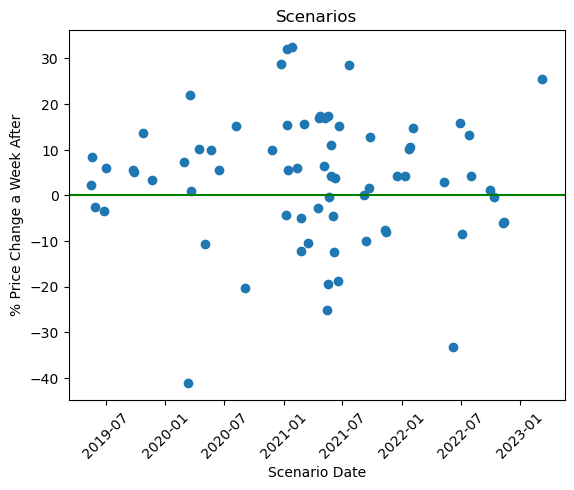

In [8]:
# Defining the scenario. In this case its ETH Low to Close wick > 3% in a day and ETH Open to Close < 0 (creates a red candle).
scenario = (final_tickers['Low_Close_%'] >= 3) & (final_tickers['Open_Close_%']< 0)

scenario = analyze_scenario(scenario)

### Second Alert Scenario: <a class="anchor" id="second"></a>

This time we bring in a scenario with the dollar to help predict what will happen in a week if it's candle is green. 

- ETH Open to Close wick > 3% in a day.
- DOLLAR Open to Close > 0 (creates green candle)

Goes Up: 65 times
Goes Down: 48 times
Total: 113 times

Price Goes Up in the Next Week: 57.52% of the time

Price Goes Down in the Next Week: 42.48% of the time

Price 3 days after the scenario: 4.64% (goes up)

Price also 3 days after the scenario: -3.39% (goes down)

Price 5 days after the scenario: 7.35% (goes up)

Price also 5 days after the scenario: -4.74% (goes down)

Weekly Future price a week after the scenario: 12.27% (goes up)

Weekly Future price also a week after the scenario: -6.92% (goes down)

Monthly Future price a month after the scenario: 21.15%

Monthly Future price also a month after the scenario: 4.82%

Quarterly Future price a quarter after the scenario: 45.92%

Quarterly Future price also a quarter after the scenario: 18.74%

The expected value for selling 3 days later: 1.23% profit

The expected value for selling 5 days later: 2.21% profit

The expected value for selling a week later: 4.12% profit

The expected value for selling a month later: 14.22% profit

Th

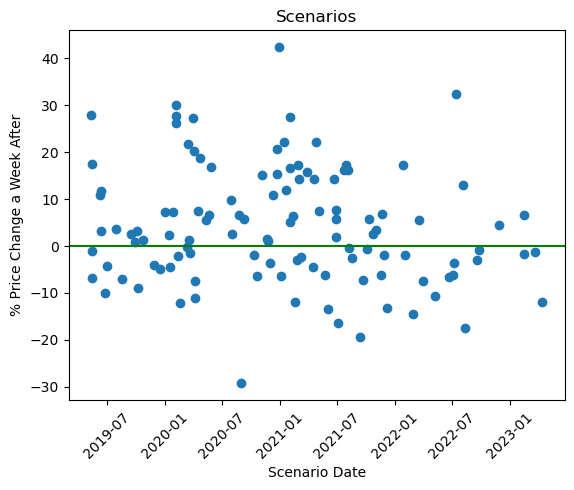

In [9]:
scenario = (final_tickers['Open_Close_%'] >= 3) & (final_tickers['dxy_Open_Close_%']> 0)

scenario = analyze_scenario(scenario)

### Third Alert Scenario: <a class="anchor" id="third"></a>

- ETH Open to Close wick < 0% in a day. (daily red candle)
- NASDAQ Past Weekly > 0.5%

Goes Up: 157 times
Goes Down: 110 times
Total: 267 times

Price Goes Up in the Next Week: 58.80% of the time

Price Goes Down in the Next Week: 41.20% of the time

Price 3 days after the scenario: 4.59% (goes up)

Price also 3 days after the scenario: -3.19% (goes down)

Price 5 days after the scenario: 7.30% (goes up)

Price also 5 days after the scenario: -4.54% (goes down)

Weekly Future price a week after the scenario: 10.51% (goes up)

Weekly Future price also a week after the scenario: -7.24% (goes down)

Monthly Future price a month after the scenario: 19.44%

Monthly Future price also a month after the scenario: 2.58%

Quarterly Future price a quarter after the scenario: 41.61%

Quarterly Future price also a quarter after the scenario: 23.92%

The expected value for selling 3 days later: 1.38% profit

The expected value for selling 5 days later: 2.42% profit

The expected value for selling a week later: 3.20% profit

The expected value for selling a month later: 12.49% profit



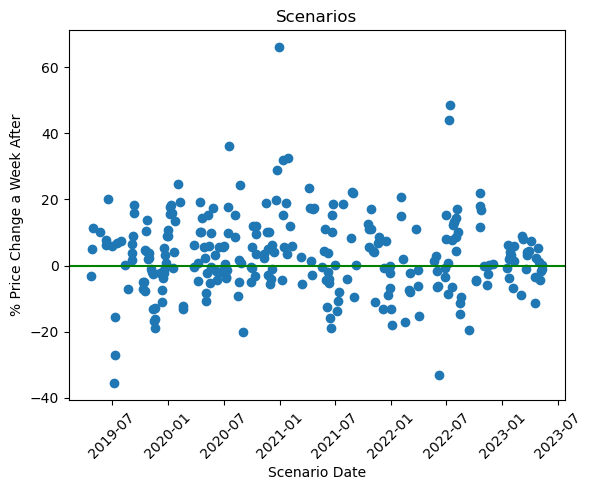

In [10]:
scenario = (final_tickers['Open_Close_%'] <= 0) & (final_tickers['ndq_Past_Weekly_%']> .5)

scenario = analyze_scenario(scenario)

### Fourth Alert Scenario: <a class="anchor" id="fourth"></a>

- ETH Open to Close  < 0 in a day. (creates a red candle)
- ETH Low to Close wick > 1.5
- NASDAQ Open to Close > .75 (creates green candle)

Goes Up: 66 times
Goes Down: 38 times
Total: 104 times

Price Goes Up in the Next Week: 63.46% of the time

Price Goes Down in the Next Week: 36.54% of the time

Price 3 days after the scenario: 6.33% (goes up)

Price also 3 days after the scenario: -4.95% (goes down)

Price 5 days after the scenario: 8.86% (goes up)

Price also 5 days after the scenario: -7.06% (goes down)

Weekly Future price a week after the scenario: 10.30% (goes up)

Weekly Future price also a week after the scenario: -9.36% (goes down)

Monthly Future price a month after the scenario: 14.59%

Monthly Future price also a month after the scenario: -8.73%

Quarterly Future price a quarter after the scenario: 43.72%

Quarterly Future price also a quarter after the scenario: 19.96%

The expected value for selling 3 days later: 2.21% profit

The expected value for selling 5 days later: 3.04% profit

The expected value for selling a week later: 3.11% profit

The expected value for selling a month later: 6.07% profit

Th

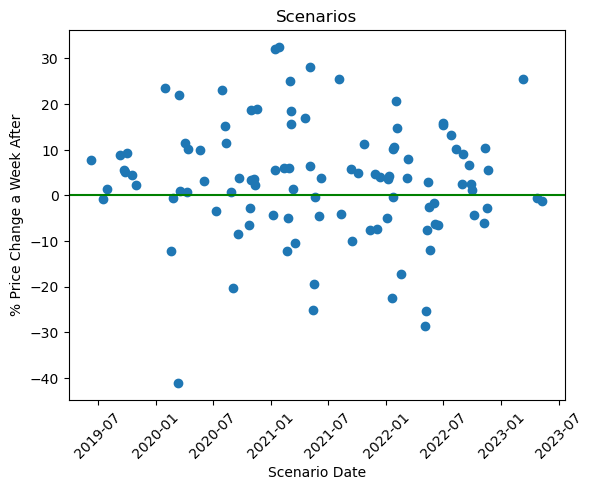

In [11]:
scenario = (final_tickers['Open_Close_%'] < 0) & (final_tickers['Low_Close_%'] >= 1.5) & (final_tickers['ndq_Low_Open_%']> .75)

scenario = analyze_scenario(scenario)

### Fifth Alert Scenario: <a class="anchor" id="fifth"></a>

- ETH Open to Close wick < 0% in a day. (red candle)
- ETH Low to Close wick > 3% in a day.
- DOLLAR Low to Open < 0.3 in a day

Goes Up: 30 times
Goes Down: 18 times
Total: 48 times

Price Goes Up in the Next Week: 62.50% of the time

Price Goes Down in the Next Week: 37.50% of the time

Price 3 days after the scenario: 4.59% (goes up)

Price also 3 days after the scenario: -3.55% (goes down)

Price 5 days after the scenario: 7.19% (goes up)

Price also 5 days after the scenario: -5.64% (goes down)

Weekly Future price a week after the scenario: 9.78% (goes up)

Weekly Future price also a week after the scenario: -10.80% (goes down)

Monthly Future price a month after the scenario: 9.78%

Monthly Future price also a month after the scenario: -0.54%

Quarterly Future price a quarter after the scenario: 40.60%

Quarterly Future price also a quarter after the scenario: 14.02%

The expected value for selling 3 days later: 1.54% profit

The expected value for selling 5 days later: 2.38% profit

The expected value for selling a week later: 2.06% profit

The expected value for selling a month later: 5.91% profit

The 

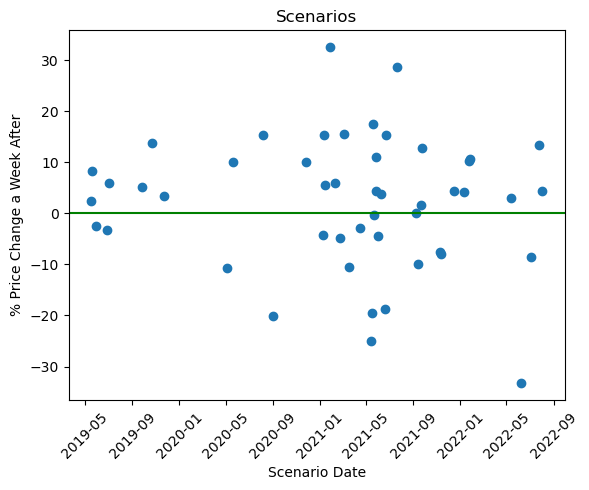

In [12]:
scenario = (final_tickers['Open_Close_%'] < 0) & (final_tickers['Low_Close_%'] >= 3) & (final_tickers['dxy_Low_Open_%']< .3)

scenario = analyze_scenario(scenario)

### Sixth Alert Scenario: <a class="anchor" id="sixth"></a>

- ETH Open to Close wick < 0% in a day. (red candle)
- ETH Low to Close wick > 1% in a day.

Goes Up: 180 times
Goes Down: 135 times
Total: 315 times

Price Goes Up in the Next Week: 57.14% of the time

Price Goes Down in the Next Week: 42.86% of the time

Price 3 days after the scenario: 5.11% (goes up)

Price also 3 days after the scenario: -4.35% (goes down)

Price 5 days after the scenario: 7.66% (goes up)

Price also 5 days after the scenario: -6.44% (goes down)

Weekly Future price a week after the scenario: 10.33% (goes up)

Weekly Future price also a week after the scenario: -8.64% (goes down)

Monthly Future price a month after the scenario: 18.21%

Monthly Future price also a month after the scenario: -2.18%

Quarterly Future price a quarter after the scenario: 46.21%

Quarterly Future price also a quarter after the scenario: 15.29%

The expected value for selling 3 days later: 1.06% profit

The expected value for selling 5 days later: 1.62% profit

The expected value for selling a week later: 2.20% profit

The expected value for selling a month later: 9.47% profit



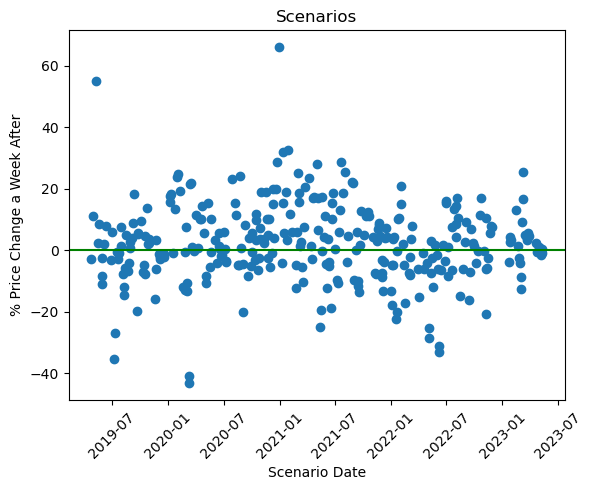

In [13]:
scenario = (eth['Open_Close_%'] <= 0) & (eth['Low_Close_%'] >= 1) 

scenario = analyze_scenario(scenario)

# Machine Learning - Predicting future price direction (up/down)<a class="anchor" id="ml"></a> 
[Back to top](#top)</br>

In [14]:
# Importing machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Logistic Regression <a class="anchor" id="lr"></a> 

### Creating a Logistic Regression for Daily Target 

In [15]:
# Initializing the model.
model = LogisticRegression()

# Creating our train and test data using the last 100 days to predict the next 100.
train = final_tickers.iloc[:-100]
test = final_tickers.iloc[-100:]

# Defining what columns we are using to predict future price direction.
predictors = ["Open_x", "High_x", "Low_x", "Close_x"]

# Training the model to use our predictors to predict next week's price direction.
model.fit(train[predictors], train["Daily_Target"])

# Using the model to make predictions on the test data.
preds = model.predict(test[predictors])

# Making arrayed predictions into a pandas Series 
preds = pd.Series(preds, index=test.index)

# Calculating how accurate the model is.
precision = precision_score(test["Daily_Target"], preds)*100
print(f"This model predicted next day's price correctly {round(precision,2)}% of the time.")
# Showing did the price go up or down and if our model predicted it.
combined = pd.concat([test["Daily_Target"], preds], axis=1)
combined

This model predicted next day's price correctly 54.12% of the time.


,Daily_Target,0
Date,,
2022-12-27,0,1
2022-12-28,1,1
2022-12-29,0,1
2022-12-30,0,1
2023-01-03,1,1
2023-01-04,0,1
2023-01-05,1,1
2023-01-06,0,1
2023-01-09,1,1


### Creating a Logistic Regression for Weekly Target

In [16]:
model = LogisticRegression()

train = final_tickers.iloc[:-100]
test = final_tickers.iloc[-100:]

predictors = ["Open_x", "High_x", "Low_x", "Close_x"]
model.fit(train[predictors], train["Weekly_Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Weekly_Target"], preds)*100
print(f"This model predicted next week's price correctly {round(precision,2)}% of the time.")
combined = pd.concat([test["Weekly_Target"], preds], axis=1)
combined

This model predicted next week's price correctly 61.11% of the time.


,Weekly_Target,0
Date,,
2022-12-27,1,1
2022-12-28,1,1
2022-12-29,1,1
2022-12-30,1,1
2023-01-03,1,1
2023-01-04,1,1
2023-01-05,1,1
2023-01-06,1,1
2023-01-09,1,1


## Random Forest Classifier <a class="anchor" id="rfc"></a> 

### Creating a Random Forest Model for Daily Target 

In [17]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = final_tickers.iloc[:-100]
test = final_tickers[-100:]

predictors = ["Open_x", "High_x", "Low_x", "Close_x"]
model.fit(train[predictors], train["Daily_Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Daily_Target"], preds)*100
print(f"This model predicted next day's price correctly {round(precision,2)}% of the time.")
combined = pd.concat([test["Daily_Target"], preds], axis=1)
combined

This model predicted next day's price correctly 50.0% of the time.


,Daily_Target,0
Date,,
2022-12-27,0,1
2022-12-28,1,1
2022-12-29,0,1
2022-12-30,0,1
2023-01-03,1,1
2023-01-04,0,0
2023-01-05,1,0
2023-01-06,0,0
2023-01-09,1,0


### Creating a Random Forest Model for Weekly Target

In [18]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

train = final_tickers.iloc[:-100]
test = final_tickers[-100:]

predictors = ["Open_x", "High_x", "Low_x", "Close_x"]

model.fit(train[predictors], train["Weekly_Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Weekly_Target"], preds)*100
print(f"This model predicted next week's price correctly {round(precision,2)}% of the time.")
combined = pd.concat([test["Weekly_Target"], preds], axis=1)
combined

This model predicted next week's price correctly 59.26% of the time.


,Weekly_Target,0
Date,,
2022-12-27,1,0
2022-12-28,1,1
2022-12-29,1,1
2022-12-30,1,1
2023-01-03,1,0
2023-01-04,1,0
2023-01-05,1,0
2023-01-06,1,0
2023-01-09,1,1


## XGBoost <a class="anchor" id="xgb"></a> 

### Creating a XGBoost Model for Daily Target 

In [19]:
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=100)

train = final_tickers.iloc[:-100]
test = final_tickers.iloc[-100:]

predictors = ["Open_x", "High_x", "Low_x", "Close_x"]
model.fit(train[predictors], train["Daily_Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Daily_Target"], preds)*100
print(f"This model predicted next day's price correctly {round(precision,2)}% of the time.")
combined = pd.concat([test["Daily_Target"], preds], axis=1)
combined

This model predicted next day's price correctly 51.02% of the time.


,Daily_Target,0
Date,,
2022-12-27,0,1
2022-12-28,1,1
2022-12-29,0,1
2022-12-30,0,1
2023-01-03,1,1
2023-01-04,0,1
2023-01-05,1,0
2023-01-06,0,0
2023-01-09,1,0


### Creating a XGBoost Model for Weekly Target

In [20]:
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=100)

train = final_tickers.iloc[:-100]
test = final_tickers.iloc[-100:]

predictors = ["Open_x", "High_x", "Low_x", "Close_x"]
model.fit(train[predictors], train["Weekly_Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Weekly_Target"], preds)*100
print(f"This model predicted next week's price correctly {round(precision,2)}% of the time.")
combined = pd.concat([test["Weekly_Target"], preds], axis=1)
combined

This model predicted next week's price correctly 70.21% of the time.


,Weekly_Target,0
Date,,
2022-12-27,1,0
2022-12-28,1,1
2022-12-29,1,1
2022-12-30,1,1
2023-01-03,1,0
2023-01-04,1,0
2023-01-05,1,1
2023-01-06,1,1
2023-01-09,1,1


## Creating a function to quickly test different predictors and models . <a class="anchor" id="function"></a> 

In [21]:
# Creating predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Weekly_Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Weekly_Target"], preds], axis=1)
    return combined

### Using the function

In [22]:
# Giving inputs for train, test, predictors, and model.
train = final_tickers.iloc[:-180]
test = final_tickers.iloc[-180:]
predictors = ["Open_x", "Close_x", "Low_x", "Close_x", "Past_Weekly_%", "dxy_Past_Weekly_%", "ndq_Past_Weekly_%"]
model = LogisticRegression()

# Executing function and determining accuracy of the model.
predictions = predict(train, test, predictors, model)

precision = precision_score(predictions["Weekly_Target"], predictions["Predictions"])* 100
print(f"This model predicted next week's price correctly {round(precision,2)}% of the time.")

This model predicted next week's price correctly 56.88% of the time.


### Is our model Accurate? 

In [23]:
# Our precision score for our predict function should be higher than the below calculation.

# Calculating % of days where the market actually went up. 
predictions["Weekly_Target"].value_counts()/predictions.shape[0]

1    0.533333
0    0.466667
Name: Weekly_Target, dtype: float64